In [1]:
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from keras_tuner.tuners import RandomSearch

2023-02-20 15:15:36.450512: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-20 15:15:36.515968: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-20 15:15:36.517990: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/ns-allinone-2.35/otcl-1.14:/opt/ns-allinone-2.35/lib
2023-02-20 15:15:36.517999: I tensor

In [2]:
df=pd.read_csv('Real_Combine.csv')
df.head()

,T,TM,Tm,SLP,H,VV,V,VM,PM 2.5
0,7.4,9.8,4.8,1017.6,93.0,0.5,4.3,9.4,219.720833
1,7.8,12.7,4.4,1018.5,87.0,0.6,4.4,11.1,182.187500
2,6.7,13.4,2.4,1019.4,82.0,0.6,4.8,11.1,154.037500
3,8.6,15.5,3.3,1018.7,72.0,0.8,8.1,20.6,223.208333
4,12.4,20.9,4.4,1017.3,61.0,1.3,8.7,22.2,200.645833


In [3]:
df.isnull().sum()

T         0
TM        0
Tm        0
SLP       0
H         0
VV        0
V         0
VM        0
PM 2.5    1
dtype: int64

In [4]:
df=df.dropna()

In [5]:
df.isnull().sum()

T         0
TM        0
Tm        0
SLP       0
H         0
VV        0
V         0
VM        0
PM 2.5    0
dtype: int64

In [6]:
x=df.iloc[:,:-1]
y=df.iloc[:,-1]

In [7]:
x.head()

,T,TM,Tm,SLP,H,VV,V,VM
0,7.4,9.8,4.8,1017.6,93.0,0.5,4.3,9.4
1,7.8,12.7,4.4,1018.5,87.0,0.6,4.4,11.1
2,6.7,13.4,2.4,1019.4,82.0,0.6,4.8,11.1
3,8.6,15.5,3.3,1018.7,72.0,0.8,8.1,20.6
4,12.4,20.9,4.4,1017.3,61.0,1.3,8.7,22.2


In [8]:
y.head()

0    219.720833
1    182.187500
2    154.037500
3    223.208333
4    200.645833
Name: PM 2.5, dtype: float64

In [13]:
def hyper_tune(param):
    model=keras.Sequential()
    for i in range(param.Int('num_layer',2,20)):
        model.add(layers.Dense(units=param.Int('units_'+str(i),
                                               min_value=32,
                                               max_value=512,
                                               step=32),
                               activation='tanh'))
        model.add(layers.Dense(1,activation='linear'))
        model.compile(
        optimizer=keras.optimizers.Adam(
        param.Choice('Learning_rate',
                    [1e-2,1e-3,1e-4])),
            loss='mean_absolute_error',
            metrics=['mean_absolute_error'])
        return model

In [14]:
tuner = RandomSearch(hyper_tune,
                     objective='val_mean_absolute_error',
                     max_trials=5,
                     executions_per_trial=3,
                     directory='project',
                     overwrite=True,
                     project_name='Air Quality Index')

In [21]:
tuner.search_space_summary()

Search space summary
Default search space size: 3
num_layer (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 20, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
Learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [22]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=0)

In [23]:
tuner.search(x_train, y_train, epochs=5, validation_data=(x_test,y_test))

INFO:tensorflow:Oracle triggered exit


In [27]:
import matplotlib.pyplot as plt
best_hps=tuner.get_best_hyperparameters(1)[0]
model=hyper_tune(best_hps)
history=model.fit(x_train,y_train,epochs=5,validation_data=(x_test,y_test))

Epoch 1/5
24/24 [==============================] - 0s 3ms/step - loss: 77.5924 - mean_absolute_error: 77.5924 - val_loss: 66.2158 - val_mean_absolute_error: 66.2158
Epoch 2/5
24/24 [==============================] - 0s 1ms/step - loss: 66.5329 - mean_absolute_error: 66.5329 - val_loss: 66.1874 - val_mean_absolute_error: 66.1874
Epoch 3/5
24/24 [==============================] - 0s 1ms/step - loss: 66.2115 - mean_absolute_error: 66.2115 - val_loss: 65.4937 - val_mean_absolute_error: 65.4937
Epoch 4/5
24/24 [==============================] - 0s 1ms/step - loss: 66.3295 - mean_absolute_error: 66.3295 - val_loss: 65.6471 - val_mean_absolute_error: 65.6471
Epoch 5/5
24/24 [==============================] - 0s 1ms/step - loss: 66.3025 - mean_absolute_error: 66.3025 - val_loss: 65.8131 - val_mean_absolute_error: 65.8131


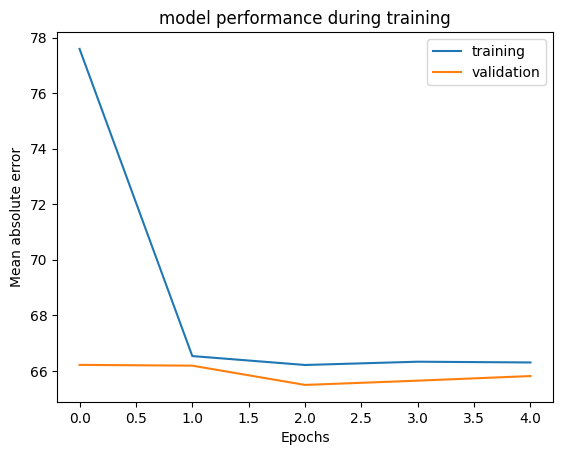

In [29]:
plt.plot(history.history['mean_absolute_error'],label='training')
plt.plot(history.history['val_mean_absolute_error'],label="validation")
plt.title('model performance during training')
plt.xlabel('Epochs')
plt.ylabel('Mean absolute error')
plt.legend()
plt.show()
